# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. Тетрадка позаимствована с [шадовского курса по нейронкам.](https://github.com/yandexdataschool/Practical_DL/blob/master/week01_backprop/adapdive_sgd/adaptive_sgd.ipynb)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

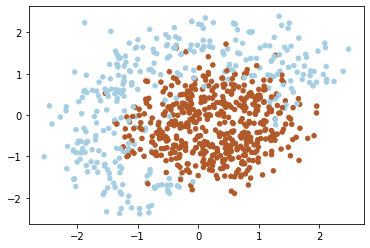

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
X

array([[ 1.20798057,  0.0844994 ],
       [ 0.76121787,  0.72510869],
       [ 0.55256189,  0.51937292],
       ...,
       [-1.22224754,  0.45743421],
       [ 0.43973452, -1.47275142],
       [ 1.4928118 ,  1.15683375]])

In [4]:
#x1**2
X[:, 0]**2

#x2**2
X[:, 1]**2

#x1*x2
X[:, 0] * X[:, 1]

#add ones


array([ 1.02073638e-01,  5.51965696e-01,  2.86985681e-01, -1.55610979e-01,
        3.43486757e+00,  8.01636977e-03,  1.12615978e+00, -6.80995241e-01,
        7.61316796e-01, -4.97328917e-01,  8.28421263e-02,  1.34354642e+00,
       -2.37240550e-02,  1.19122151e+00, -1.03339309e-01,  5.99390912e-01,
        2.80977365e+00, -9.51397649e-01,  3.91574453e-01,  3.08210831e+00,
        3.00005781e-01, -2.03166177e-01, -4.36144172e-01, -2.90360381e-02,
        2.28087514e-02, -1.12247037e+00,  2.39252110e+00,  2.24245870e+00,
       -7.12330300e-01, -7.74052553e-03, -5.05608554e-01,  1.26514304e-01,
       -3.48694906e-01, -8.71072548e-02,  4.56784383e-01, -4.79875917e-01,
       -2.27070748e-01,  1.81411932e-01,  2.50059568e+00, -4.64100659e-01,
       -1.70211216e-01,  2.61446440e+00, -2.61965192e-03,  3.53204616e+00,
        1.27135830e+00,  1.97205517e+00, -1.49747579e-01,  1.69705322e+00,
        4.29286038e-01,  3.86950011e-02,  3.89574074e-01, -1.78302626e+00,
        1.69300742e+00, -

In [5]:
(X[:, 0] * X[:, 1]).reshape(X.shape[0],1).shape

(826, 1)

In [6]:
X.shape

(826, 2)

In [7]:
np.ones(10).reshape(10,1)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [8]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    # calc dimensions od X
    n, m = X.shape

    #calc and add x1**2
    feature_1 = (X[:, 0]**2).reshape(n,1)
    X = np.hstack((X, feature_1))
    
    #calc and add x2**2
    feature_2 = (X[:, 1]**2).reshape(n,1)
    X = np.hstack((X, feature_2))

    #calc and add x1*x2
    feature_3 = (X[:, 0] * X[:, 1]).reshape(n,1)
    X = np.hstack((X, feature_3))

    #add ones
    X = np.hstack((X, np.ones(n).reshape(n,1)))
    
    return X

### [3] Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [9]:
w_test = np.random.rand(6)

In [10]:
expand(X).dot(w_test).mean()

0.7841162734466243

In [31]:
probability(expand(X), w_test).shape

(826,)

In [14]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    logits = X.dot(w)
    return 1/(1+np.exp(logits))

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [12]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """

    N = X.shape[0]
    predicts = probability(X, w)
    predicts = [min([max([x,1e-15]),1-1e-15]) for x in predicts]
    # print([y[i]*np.log(predicts[i]) + (1.0-y[i])*np.log(1.0-predicts[i]) for i in N])
    return -(1.0/N)*sum([y[i]*np.log(predicts[i]) + (1.0-y[i])*np.log(1.0-predicts[i]) for i in range(N)])  

In [16]:
# проверочка
from sklearn.metrics import log_loss
log_loss(y, probability(expand(X), w_test))

0.891288933703384

In [17]:
compute_loss(expand(X), y, w_test)

0.8912889337033844

Проверка пройдена)

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

t - фактич значение

y - предсказ значение


In [25]:
compute_grad(expand(X), y, w_test).shape

(826,)

In [19]:
def compute_grad(X, y, w):
    """
    Находит значение градиента.
    """

    return 2*probability(X, w) - compute_loss(X, y, w)

Функция ниже предназначена для визуализации процесса обучения. 

In [20]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

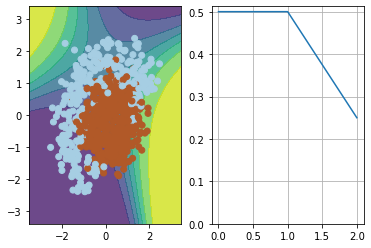

In [59]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

In [27]:
# Define the logistic function
def logistic(z): 
    return 1. / (1 + np.exp(-z))

# Define the neural network function y = 1 / (1 + numpy.exp(-x*w))
def nn(x, w): 
    return logistic(x.dot(w.T))

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x,w): 
    return np.around(nn(x,w))
    
# Define the loss function
def loss(y, t):
    return - np.mean(
        np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

def gradient(w, x, t):
    """Gradient function. (Remember that y = nn(x, w) = x * w)"""
    return 2 * x * (nn(x, w) - t)

def delta_w(w_k, x, t, learning_rate):
    """Update function delta w"""
    return learning_rate * np.mean(gradient(w_k, x, t))

In [51]:
expand(X).T @ (probability(expand(X), w_test) - y) 

array([-254.8854864 ,   89.93200058,  -14.06310799,  -44.18256183,
         56.53913995, -221.91705137])

In [ ]:
# Initial weight parameter
w = np.random.rand()
# Set the learning rate
learning_rate = 0.9

# Perform the gradient descent updates, and print the weights and loss:
nb_of_iterations = 4  # number of gradient descent updates
w_loss = [(w, loss(nn(x, w), t))] # Keep track of weight and loss values
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # Delta w update
    w = w - dw  # Update the current weight parameter
    w_loss.append((w, loss(nn(x, w), t)))  # Save weight and loss

# Print the final w, and loss
for i in range(0, len(w_loss)):
    print(f'w({i}): {w_loss[i][0]:.4f} \t loss: {w_loss[i][1]:.4f}')

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



In [ ]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    
    # Ваш код здесь 

visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


In [ ]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    
    # Ваш код здесь 

visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

In [ ]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):

    # Ваш код здесь 

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть дополнительные баллы за реализацию каждой новой адекватной вариации. 

In [ ]:
# Ваш код здесь 